# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    ### STUDENT START ###
    
    # separate examples wiht lines to look more organized visually
    line = '-'*75
    
    # enumerate over training examples and print message text along with label category
    for index, text in enumerate(train_data[:num_examples]):
        print(f'Message Example {index+1}:\n{text}\n \
              \nLabel Category {train_labels[index]}: {newsgroups_train.target_names[train_labels[index]]}\n{line}')
        
    ### STUDENT END ###

P1(5)

Message Example 1:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
               
Label Category 1: comp.graphics
---------------------------------------------------------------------------
Message Example 2:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, cir

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    ### STUDENT START ###

    # Part A - Transform the training data into a matrix of word unigram feature vectors
    count_vectorizer = CountVectorizer()
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    print('Part A - Initial Matrix of Word Unigram Feature Vectors')
    print(f'Size of Vocabulary: {feature_vectors.shape[1]}')
#     print(f'Size of Vocabulary: {len(count_vectorizer.vocabulary_)}')
    print(f'Average Number of Non-Zero Features per Example: {feature_vectors.getnnz(axis=1).mean():.4f}')
    print(f'Fraction of Non-Zero Matrix Entries: {feature_vectors.nnz/(feature_vectors.shape[0]*feature_vectors.shape[1]):.4f}')
    print(f'The 0th and Last Feature Strings: {count_vectorizer.get_feature_names()[0], count_vectorizer.get_feature_names()[-1]}')    
    
    # Part B - Transform the training data into a matrix of word unigram feature vectors using your own vocabulary
    vocab_count_vectorizer = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    vocab_feature_vectors = vocab_count_vectorizer.transform(raw_documents=train_data)
    print('\nPart B - Custom Vocabulary')
    print(f'Size of Vocabulary: {vocab_feature_vectors.shape[1]}')
    print(f'Average Number of Non-Zero Features per Example: {vocab_feature_vectors.getnnz(axis=1).mean():.4f}')
    
    # Part C - Transform the training data into a matrix of character bigram and trigram feature vectors
    bi_trigram_count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2,3))
    bi_trigram_feature_vectors = bi_trigram_count_vectorizer.fit_transform(raw_documents=train_data)
    print('\nPart C - Bigram and Trigram Character')
    print(f'Size of Vocabulary: {bi_trigram_feature_vectors.shape[1]}')
    
    # Part D - Transform the training data into a matrix of word unigram feature vectors 
    # and prune words that appear in fewer than 10 documents
    prune_count_vectorizer = CountVectorizer(min_df=10)
    prune_feature_vectors = prune_count_vectorizer.fit_transform(raw_documents=train_data)
    print('\nPart D - Pruned Words')
    print(f'Size of Vocabulary: {prune_feature_vectors.shape[1]}')
    
    # Part E - Transform the training data into a matrix of word unigram feature vectors 
    dev_count_vectorizer = CountVectorizer()
    dev_feature_vectors = dev_count_vectorizer.fit_transform(raw_documents=dev_data)
    num_diff = len(set(dev_count_vectorizer.get_feature_names()).difference(count_vectorizer.get_feature_names()))
    print('\nPart E - Difference in Dev and Trained Data')
    print(f'Fraction of Words in Development Missing from Training Vocabulary: {num_diff/dev_feature_vectors.shape[1]:.4f}')

    ### STUDENT END ###

P2()

Part A - Initial Matrix of Word Unigram Feature Vectors
Size of Vocabulary: 26879
Average Number of Non-Zero Features per Example: 96.7060
Fraction of Non-Zero Matrix Entries: 0.0036
The 0th and Last Feature Strings: ('00', 'zyxel')

Part B - Custom Vocabulary
Size of Vocabulary: 4
Average Number of Non-Zero Features per Example: 0.2684

Part C - Bigram and Trigram Character
Size of Vocabulary: 35478

Part D - Pruned Words
Size of Vocabulary: 3064

Part E - Difference in Dev and Trained Data
Fraction of Words in Development Missing from Training Vocabulary: 0.2479


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():
    ### STUDENT START ###
    
    count_vectorizer = CountVectorizer()
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
    
    # kNN
    print('kNN Models:')
    k_values = [x for x in range(1, 200, 10)] 
    k_max_score = []
    for k in k_values:
        knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        knn_model.fit(feature_vectors, train_labels)
        knn_f1score = metrics.f1_score(dev_labels, knn_model.predict(dev_feature_vectors), average='weighted')
        k_max_score.append(knn_f1score)
        print(f'k = {k}, f1-score = {knn_f1score:.4f}')
    print(f'\nOptimum f1-score = {max(k_max_score):.4f} using k = {k_values[k_max_score.index(max(k_max_score))]}')

    # NB
    print('\nNaive Bayes Models:')
    alpha_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100] 
    alpha_max_score = []
    for alpha in alpha_values:
        multinb_model = MultinomialNB(alpha=alpha)
        multinb_model.fit(feature_vectors, train_labels)
        multinb_f1score = metrics.f1_score(dev_labels, multinb_model.predict(dev_feature_vectors), average='weighted')
        alpha_max_score.append(multinb_f1score)
        print(f'alpha = {alpha}, f1-score = {multinb_f1score:.4f}')
    print(f'\nOptimum f1-score = {max(alpha_max_score):.4f} using alpha = {alpha_values[alpha_max_score.index(max(alpha_max_score))]}')
    
    # Logistic Regression
    print('\nLogistic Regression Models:')
    c_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100] 
    c_max_score = []
    for c in c_values:
        logreg_model = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        logreg_model.fit(feature_vectors, train_labels)
        logreg_f1score = metrics.f1_score(dev_labels, logreg_model.predict(dev_feature_vectors), average='weighted')
        c_max_score.append(logreg_f1score)
        print(f'C = {c}, f1-score = {logreg_f1score:.4f}')
        
        # Sum of squared weights for each topic
        print(f'  Sum of Squared Weights:')
        for i, weight in enumerate(newsgroups_train.target_names):
            print(f'    {i+1}. {weight} = {np.sum(np.square(logreg_model.coef_[i])):.4f}')
        print()    
    print(f'Optimum f1-score = {max(c_max_score):.4f} using C = {c_values[c_max_score.index(max(c_max_score))]}')        
            
P3()

kNN Models:
k = 1, f1-score = 0.3805
k = 11, f1-score = 0.4266
k = 21, f1-score = 0.4261
k = 31, f1-score = 0.4470
k = 41, f1-score = 0.4633
k = 51, f1-score = 0.4136
k = 61, f1-score = 0.4400
k = 71, f1-score = 0.4490
k = 81, f1-score = 0.4404
k = 91, f1-score = 0.4535
k = 101, f1-score = 0.4467
k = 111, f1-score = 0.4757
k = 121, f1-score = 0.4561
k = 131, f1-score = 0.4443
k = 141, f1-score = 0.4387
k = 151, f1-score = 0.4225
k = 161, f1-score = 0.4119
k = 171, f1-score = 0.3999
k = 181, f1-score = 0.4066
k = 191, f1-score = 0.4100

Optimum f1-score = 0.4757 using k = 111

Naive Bayes Models:
alpha = 0.0001, f1-score = 0.7628
alpha = 0.001, f1-score = 0.7703
alpha = 0.01, f1-score = 0.7752
alpha = 0.1, f1-score = 0.7903
alpha = 0.5, f1-score = 0.7863
alpha = 1, f1-score = 0.7777
alpha = 2, f1-score = 0.7690
alpha = 10, f1-score = 0.6675
alpha = 100, f1-score = 0.5101

Optimum f1-score = 0.7903 using alpha = 0.1

Logistic Regression Models:
C = 0.0001, f1-score = 0.5416
  Sum of Squa

ANSWER:

**Why doesn't k-Nearest Neighbors work well for this problem?**

It does not work well for this problem due to the high dimension of feature space (26879) and sparse nature of the feature matrix. All the data points are wide apart and the training dataset does not provide good sampling of the feature space. Due to the sparsity of the feature matrix (huge vocabulary but each document does not contain most words), the kNN model experiences difficulty distinguishing one document to the next. This is also made worse when common words such as 'is', 'the', 'to' and so on are prevalent between documents and are given additional importance in the prediction.

**Why doesn't Logistic Regression work as well as Naive Bayes does?**

Logistic Regression does not work as well as Naive Bayes Multinomial in this case as the events are somewhat independent (although word placement/grammar is not independent, bag-of-words modelling style on features create independence without preserving word context) which leads to better prediction. In addition, the training dataset is small, the model is generative and non-linear. The high amount of common words produces noisiness and thus, it is hard to fit an accurate line in the logistic regression model. If the training data size is increased, the logistic regression model is expected to perform better compared to current.

**What is the relationship between logistic regression's sum of squared weights vs. C value?**

C-value is inversely proportional to strength of regularization/penalty. As C increases, the sum of squared weights increases. In other words, the higher the C-value, the lower the regularization strength/penalty, the higher the number of features used. Regularization penalizes large coefficients and drives them towards zero to reduce overfitting as well as increase parsimony of the model.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value.

In [6]:
def P4():   
    ### STUDENT START ###
    
    count_vectorizer = CountVectorizer(ngram_range=(2,2))
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    
    topic = newsgroups_train.target_names
    LR = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    LR.fit(feature_vectors, train_labels)
    
    # Sort indices by element value
    top_5_features = np.argsort(LR.coef_, axis = 1)[:,-5:]

    print(
        f'Bigram Table:\n'
        f'\t\t{topic[0]}\t{topic[1]}\t{topic[2]}\t{topic[3]}'
    )

    # Iterate through each topic and obtain top 5 features with largest weights
    for x in range(4):
        
        # Print from highest to lowest weight (4 to 0)
        for y in range (4, -1, -1):
            coef_1, coef_2, coef_3, coef_4 = LR.coef_[:, top_5_features[x, y]]
            print(
                f'{count_vectorizer.get_feature_names()[top_5_features[x, y]]:15s}'
                f'\t{coef_1:.2f}\t\t{coef_2:.2f}\t\t{coef_3:.2f}\t\t{coef_4:.2f}'
            )

    ### STUDENT END ###

P4()

Bigram Table:
		alt.atheism	comp.graphics	sci.space	talk.religion.misc
claim that     	0.61		-0.20		-0.27		-0.14
cheers kent    	0.56		-0.70		-0.66		0.53
was just       	0.48		-0.13		-0.13		-0.23
you are        	0.47		-0.28		-0.48		0.03
are you        	0.45		-0.25		-0.10		-0.31
looking for    	-0.63		1.11		-0.50		-0.57
in advance     	-0.46		0.83		-0.44		-0.42
comp graphics  	-0.29		0.80		-0.37		-0.29
out there      	-0.27		0.76		-0.48		-0.28
is there       	-0.34		0.75		-0.47		-0.26
the space      	-0.27		-0.53		0.87		-0.27
the moon       	-0.35		-0.49		0.83		-0.21
sci space      	-0.26		-0.33		0.62		-0.22
and such       	-0.20		-0.34		0.59		-0.22
it was         	-0.20		-0.31		0.53		-0.31
the fbi        	-0.13		-0.21		-0.30		0.55
cheers kent    	0.56		-0.70		-0.66		0.53
ignorance is   	-0.16		-0.17		-0.14		0.50
but he         	-0.19		-0.22		-0.14		0.49
of jesus       	-0.09		-0.17		-0.21		0.42


ANSWER:

It is surprising that the bigram model contains more generic words and word interpretability or context is somewhat lost. It also appears that most of the largest weighted words are 'stop words'. For example, 'was just', 'you are', 'are you' and so on are common which demonstrates the main issue of text classification - modelling English language is hard due to difficult categorization. It is certainly interesting that 'cheers kent' appeared under both atheism and religion topics. The other interesting observation is that 'the fbi' was the top feature under the religion topic.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
def no_preprocessor(s):
    return s

def better_preprocessor(s):
    ### STUDENT START ###
    
    s = s.lower() # Lower case
    s = re.sub('([\d]+)', 'number', s) # Replacing sequences of numbers with single tokens
    s = re.sub('[^A-Za-z0-9 \\n]', ' ', s) # Remove non-alphanumeric characters
    s = re.sub('(\w{5})\w+', '\\1', s) # Shorten words to 5 characters or fewer
    s = ' '.join([word for word in s.split(' ') 
                  if word not in ENGLISH_STOP_WORDS]) # Remove defined stop words   
    
    return s
    
    ### STUDENT END ###

def P5():
    ### STUDENT START ###
    
    # No preprocessor
    count_vectorizer = CountVectorizer(preprocessor=no_preprocessor)
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
    
    LR = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    LR.fit(feature_vectors, train_labels)
    
    f1_score = metrics.f1_score(dev_labels, LR.predict(dev_feature_vectors), average='weighted')

    vocab_size_noPreprocessor = feature_vectors.shape[1] #len(count_vectorizer.vocabulary_)
    print(
        f'No preprocessor:\n'
        f'\tf1-score: {f1_score:.4f}\n\tVocabulary Size: {vocab_size_noPreprocessor}'
    )
    
    # Better preprocessor
    count_vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
    
    LR = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    LR.fit(feature_vectors, train_labels)
    
    f1_score_improved = metrics.f1_score(dev_labels, LR.predict(dev_feature_vectors), average='weighted')

    vocab_size_improved = feature_vectors.shape[1] #len(count_vectorizer.vocabulary_)
    print(
        f'\nImproved preprocessor:\n'
        f'\tf1-score: {f1_score_improved:.4f}\n\tVocabulary Size: {vocab_size_improved}'
    )
    
    # Deltas
    score_delta = f1_score_improved - f1_score
    vocab_delta = vocab_size_noPreprocessor - vocab_size_improved
    percent_reduce_vocab = vocab_delta/vocab_size_noPreprocessor*100
    
    print(
        f'\nThe improved model increased the f1 score by {score_delta:.4f}.'
        f'\nThe improved model reduced the vocabulary size by '
        f'{vocab_delta}({percent_reduce_vocab:.1f}%).'
    )
    ### STUDENT END ###

P5()

No preprocessor:
	f1-score: 0.7069
	Vocabulary Size: 33291

Improved preprocessor:
	f1-score: 0.7314
	Vocabulary Size: 14392

The improved model increased the f1 score by 0.0244.
The improved model reduced the vocabulary size by 18899(56.8%).


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

L1 f1-score(full vocabulary & C=0.01) = 0.4230
Vocabulary Size = 17
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.4678

L1 f1-score(full vocabulary & C=0.05) = 0.5785
Vocabulary Size = 120
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.6343

L1 f1-score(full vocabulary & C=0.1) = 0.6493
Vocabulary Size = 211
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.6942

L1 f1-score(full vocabulary & C=0.2) = 0.6936
Vocabulary Size = 366
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.6887

L1 f1-score(full vocabulary & C=0.5) = 0.6880
Vocabulary Size = 746
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.6593

L1 f1-score(full vocabulary & C=1) = 0.6938
Vocabulary Size = 1058
L2 f1-score(full vocabulary & C=0.5) = 0.6950
L2 f1-score(reduced vocabulary & C=0.5) = 0.6847

L1 f1-score(full

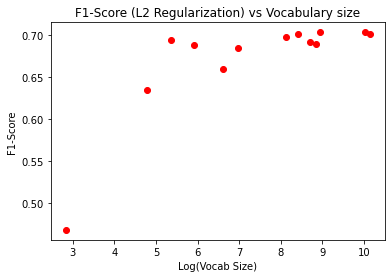

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ### STUDENT START ###
    
    c_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 25, 50, 75, 100, 500, 1000] 
    f1score_L1 = []
    f1score_L2_full = []
    f1score_L2 = []
    vocab_size = []
    
    for c in c_values:
        # L1 Regularization
        count_vectorizer = CountVectorizer()
        feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
        dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
        
        LR_one = LogisticRegression(penalty='l1', solver='liblinear', 
                                    multi_class='auto', tol=0.015, C=c)
        LR_one.fit(feature_vectors, train_labels)
        LR_one_f1score = metrics.f1_score(dev_labels, 
                                          LR_one.predict(dev_feature_vectors), 
                                          average='weighted')
        f1score_L1.append(LR_one_f1score)
        
        # L2 Regularization with Full Vocabulary and C = 0.5
        count_vectorizer = CountVectorizer()
        feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
        dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
        
        LR_two_full = LogisticRegression(penalty='l2', solver='liblinear', 
                                         multi_class='auto', tol=0.015, C=0.5)
        LR_two_full.fit(feature_vectors, train_labels)
        LR_two_full_f1score = metrics.f1_score(dev_labels, 
                                          LR_two_full.predict(dev_feature_vectors), 
                                          average='weighted')
        f1score_L2_full.append(LR_two_full_f1score)
        
        # Reduce vocabulary to only at least one non-zero weight among the four categories
        nonzero_wt = np.unique(np.nonzero(LR_one.coef_)[1])
        nonzero_vocab = np.array(count_vectorizer.get_feature_names())[nonzero_wt]
        vocab_size.append(np.log(len(nonzero_vocab)))
        
        # L2 Regularization with Reduced Vocabulary and C = 0.5
        count_vectorizer = CountVectorizer(vocabulary=nonzero_vocab)
        feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
        dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
        
        LR_two = LogisticRegression(penalty='l2', solver='liblinear', 
                                    multi_class='auto', tol=0.015, C=0.5)
        LR_two.fit(feature_vectors, train_labels)
        LR_two_f1score = metrics.f1_score(dev_labels, 
                                          LR_two.predict(dev_feature_vectors), 
                                          average='weighted')
        f1score_L2.append(LR_two_f1score)
        
        print(
            f'L1 f1-score(full vocabulary & C={c}) = {LR_one_f1score:.4f}'
            f'\nVocabulary Size = {len(nonzero_vocab)}'
            f'\nL2 f1-score(full vocabulary & C=0.5) = {LR_two_full_f1score:.4f}'
            f'\nL2 f1-score(reduced vocabulary & C=0.5) = {LR_two_f1score:.4f}\n'
        )
    
    plt.plot(vocab_size, f1score_L2, 'ro')
    plt.xlabel('Log(Vocab Size)')
    plt.ylabel('F1-Score')
    plt.title('F1-Score (L2 Regularization) vs Vocabulary size')
    
    ### STUDENT END ###

P6()

ANSWER:

The performance fo the models based on reduced vocabularies appeared to be worse off at size of less than ~6000 compared to the full vocabulary base model (f1-score: 0.6937 < 0.6950). A reduction in vocabulary size indicates a reduction in model complexity. However, if performance becomes worse when complexity is decreased, it means that there is an opportunity to increase model complexity in order to improve generalization.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7():
    ### STUDENT START ###
    
    # CountVectorizer
    count_vectorizer = CountVectorizer()
    feature_vectors = count_vectorizer.fit_transform(raw_documents=train_data)
    dev_feature_vectors = count_vectorizer.transform(raw_documents=dev_data)
    
    LR_cv = LogisticRegression(penalty='l2', C=100, solver='liblinear', multi_class='auto')
    LR_cv.fit(feature_vectors, train_labels)
    LR_cv_f1score = metrics.f1_score(dev_labels,
                                     LR_cv.predict(dev_feature_vectors),
                                     average='weighted')
    # TfidfVectorizer
    tv_vectorizer = TfidfVectorizer()
    tv_feature_vectors = tv_vectorizer.fit_transform(raw_documents=train_data)
    tv_dev_feature_vectors = tv_vectorizer.transform(raw_documents=dev_data)
    
    LR_tv = LogisticRegression(penalty='l2', C=100, solver='liblinear', multi_class='auto')
    LR_tv.fit(tv_feature_vectors, train_labels)
    LR_tv_f1score = metrics.f1_score(dev_labels,
                                     LR_tv.predict(tv_dev_feature_vectors),
                                     average='weighted')
    
    print(
        f'f1-score(CountVectorizer) = {LR_cv_f1score:.4f}\n'
        f'f1-score(TfidfVectorizer) = {LR_tv_f1score:.4f}\n'
    
    )
           
    # Predicted probabilities
    pred_proba = LR_tv.predict_proba(tv_dev_feature_vectors)
    
    # Compute R ratio
    r_ratio = []
    for i, row in enumerate(pred_proba):
        max_pred_proba = np.amax(row)
        pred_proba_correct_label = row[dev_labels[i]]
        r_ratio.append(max_pred_proba/pred_proba_correct_label)
    
    # Print top 3 highest R ratio documents
    print(f'Top Three Highest R Ratio Documents:\n')
    top3 = np.argsort(np.array(r_ratio))[-3:]
    dashes = '-'*75
    for i in reversed(top3):
        print(
            f'Example {i}\n'
            f'R ratio: {r_ratio[i]:.2f}\n'
            f'Actual Topic: {newsgroups_train.target_names[dev_labels[i]]}\n'
            f'Predicted Topic: {newsgroups_train.target_names[LR_tv.predict(tv_dev_feature_vectors)[i]]}\n'
            f'\nDocument Text: \n{dev_data[i]}\n'
            f'{dashes}\n'
        )
        
    ### STUDENT END ###

P7()

f1-score(CountVectorizer) = 0.6828
f1-score(TfidfVectorizer) = 0.7598

Top Three Highest R Ratio Documents:

Example 215
R ratio: 929.36
Actual Topic: talk.religion.misc
Predicted Topic: comp.graphics

Document Text: 
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, c

ANSWER:

**How is `TfidfVectorizer` different than `CountVectorizer`?**

`CountVectorizer` computes a specific feature frequency in each document while `TfidfVectorizer` does the same thing in addition to multiplying the frequency with its inverse frequency across all documents. The disadvantage of the `CountVectorizer` is that the document size is not accounted for thus the bias of overweighting features that appear several times in a smaller document size will occur. As `TfidfVectorizer` takes into account all documents and normalizes the frequency of each feature based on document size, biases of overweighting or underweighting features are smaller.

**Explain what the R ratio describes. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**

Overall, the f1-score for the `TfidfVectorizer` is higher than `CountVectorizer`. However, frequency does not always suggest importance especially in terms of stop words. Words could mean differently based on context. We used R ratio to rank the top three examples that are mislabelled. It basically describes the probability of a topic being mislabelled. 

An issue we observed is that the model mislabelled two `talk.religion.misc` topics as `comp.graphics` instead as it is putting more emphasis on terms such as postscript, ftp site, postscript, email, RTF, internet, email and so on. In reality, 'Mormon' probably should have been weighted higher although the frequency was low. In the third example, `alt.atheism` and `talk.religion.misc` topics have many terms in common thus it is not surprising that both topics are easily misclassified. 

A possible solution to address this problem is to remove top stop words or add additional labelled data in which terms such as 'Mormon' has a higher term frequency weight.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [10]:
def P8():
    ### STUDENT START ###
    
    # TfidfVectorizer
    tv_vectorizer = TfidfVectorizer()
    tv_feature_vectors = tv_vectorizer.fit_transform(raw_documents=train_data)
    tv_dev_feature_vectors = tv_vectorizer.transform(raw_documents=dev_data)
    
    LR_tv = LogisticRegression(penalty='l2', C=100, solver='liblinear', multi_class='auto')
    LR_tv.fit(tv_feature_vectors, train_labels)
    LR_tv_f1score = metrics.f1_score(dev_labels,
                                     LR_tv.predict(tv_dev_feature_vectors),
                                     average='weighted')
    
    # TfidfVectorizer with stop words removed
    tv_vectorizer1 = TfidfVectorizer(stop_words='english')
    tv_feature_vectors1 = tv_vectorizer1.fit_transform(raw_documents=train_data)
    tv_dev_feature_vectors1 = tv_vectorizer1.transform(raw_documents=dev_data)
    
    LR_tv1 = LogisticRegression(penalty='l2', C=100, solver='liblinear', multi_class='auto')
    LR_tv1.fit(tv_feature_vectors1, train_labels)
    LR_tv_f1score1 = metrics.f1_score(dev_labels,
                                     LR_tv1.predict(tv_dev_feature_vectors1),
                                     average='weighted')
    
    # display f1 scores
    print(
        f'f1-score(TfidfVectorizer) = {LR_tv_f1score:.4f}\n'
        f'f1-score(Improved - Set Stop Words) = {LR_tv_f1score1:.4f}\n'
        f'Improvement = {100*(LR_tv_f1score1-LR_tv_f1score)/LR_tv_f1score:.2f}%'    
    )
        
    ### STUDENT END ###

P8()

f1-score(TfidfVectorizer) = 0.7598
f1-score(Improved - Set Stop Words) = 0.7769
Improvement = 2.25%
